In [1]:
import keras_core as ks
from keras_core import ops
from sklearn.model_selection import train_test_split
# from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

from kgcnn.literature.GNNExplain import GNNExplainer, GNNInterface
from kgcnn.literature.GCN import make_model
from kgcnn.training.scheduler import LinearLearningRateScheduler

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

from kgcnn.data.datasets.MutagenicityDataset import MutagenicityDataset

Using TensorFlow backend


## Load data

In [2]:
model_inputs = [
    {'shape': (None, 14), 'name': "node_attributes", 'dtype': 'float32'},
    {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32'},
    {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64'},
    {"shape": (), "name": "total_nodes", "dtype": "int64"},
    {"shape": (), "name": "total_edges", "dtype": "int64"}
]

In [3]:
dataset = MutagenicityDataset()
dataset.map_list(method="count_nodes_and_edges")
for i in range(len(dataset)):
    # Make edge feature dimension
    dataset[i]["edge_attributes"] = np.expand_dims(dataset[i]["edge_attributes"], axis=-1).astype(np.float32)
    # Make One-Hot encoding
    dataset[i]["node_attributes"] = np.array(np.expand_dims(dataset[i]["node_attributes"] ,axis=-1) == np.array(
        [[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]]), dtype="int") 
train_indices, test_indices = train_test_split(np.arange(len(dataset)),  train_size=0.8, random_state=1)
dataset_train, dataset_test = dataset[train_indices], dataset[test_indices]
xtrain = dataset_train.tensor(model_inputs)
xtest = dataset_test.tensor(model_inputs)
ytrain = dataset_train.tensor({"name": "graph_labels"})
ytest = dataset_test.tensor({"name": "graph_labels"})
print([x.shape for x in xtrain])
print([x.shape for x in xtest])
print(ytrain.shape, ytest.shape)

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name Mutagenicity
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting zip file. Stopped.
INFO:kgcnn.data.Mutagenicity:Reading dataset to memory with name Mutagenicity
INFO:kgcnn.data.Mutagenicity:Shift start of graph ID to zero for 'Mutagenicity' to match python indexing.
INFO:kgcnn.data.Mutagenicity:Graph index which has unconnected '[  38  133  166  171  220  246  268  278  286  296  302  305  309  339
  357  439  470  497  527  706  743  783  815  861  878  902  918 1029
 1040 1044 1057 1085 1193 1233 1329 1394 1431 1525 1528 1532 1609 1645
 1696 1915 1971 2024 2026 2036 2069 2133 2138 2142 2143 2174 2193 2210
 2234 2258 2360 2422 2440 2471 2482 2483 2503 2553 2559 2604 2627 26

[(3469, 103, 14), (3469, 216, 1), (3469, 216, 2), (3469,), (3469,)]
[(868, 99, 14), (868, 224, 1), (868, 224, 2), (868,), (868,)]
(3469, 1) (868, 1)


## Make and train GCN

INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'GCN', 'inputs': [{'shape': (None, 14), 'name': 'node_attributes', 'dtype': 'float32'}, {'shape': (None, 1), 'name': 'edge_attributes', 'dtype': 'float32'}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64'}, {'shape': (), 'name': 'total_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'total_edges', 'dtype': 'int64'}], 'input_tensor_type': 'padded', 'input_embedding': {'node': {'input_dim': 55, 'output_dim': 64}, 'edge': {'input_dim': 10, 'output_dim': 64}}, 'cast_disjoint_kwargs': {}, 'input_node_embedding': {'input_dim': 95, 'output_dim': 64}, 'input_edge_embedding': {'input_dim': 25, 'output_dim': 1}, 'gcn_args': {'units': 64, 'use_bias': True, 'activation': 'relu', 'pooling_method': 'mean'}, 'depth': 3, 'verbose': 1, 'node_pooling_args': {'pooling_method': 'scatter_sum'}, 'output_embedding': 'graph', 'output_to_tensor': None, 'output_tensor_type': 'padded', 'output_mlp': {'use_bias': [True, True, False], 'units': 

Model: "GCN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_attributes (InputLayer)  │ (None, None, 14)          │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ edge_indices (InputLayer)     │ (None, None, 2)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_edges (InputLayer)      │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 14), (None),      │           0 │ node_attributes[0][0],         │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │             │ total_nodes[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ edge_attributes (InputLayer)  │ (None, None, 1)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None, 14), (2, None),   │           0 │ node_attributes[0][0],         │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │             │ edge_indices[0][0],            │
│                               │ (None), (None), (None)]   │             │ total_nodes[0][0],             │
│                               │                           │             │ total_edges[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │         960 │ cast_batched_attributes_to_di… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 1), (None),       │           0 │ edge_attributes[0][0],         │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │             │ total_edges[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gcn (GCN)                     │ (None, 64)                │       4,160 │ dense[0][0],                   │
│                               │                           │             │ cast_batched_attributes_to_di… │
│                               │                           │             │ cast_batched_indices_to_disjo… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gcn_1 (GCN)                   │ (None, 64)                │       4,160 │ gcn[0][0],                     │
│                               │                           │             │ cast_batched_attributes_to_di… │
│                               │                           │             │ cast_batched_indices_to_disjo… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gcn_2 (GCN)                   │ (None, 64)                │       4,160 │ gcn_1[0][0],                   │
│                               │                           │             │ cast_batched_attributes_to_di… │
│                               │                           │             │ 

 Total params: 32,480 (126.88 KB)

 Trainable params: 32,480 (126.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Print Time for taining:  372.28125


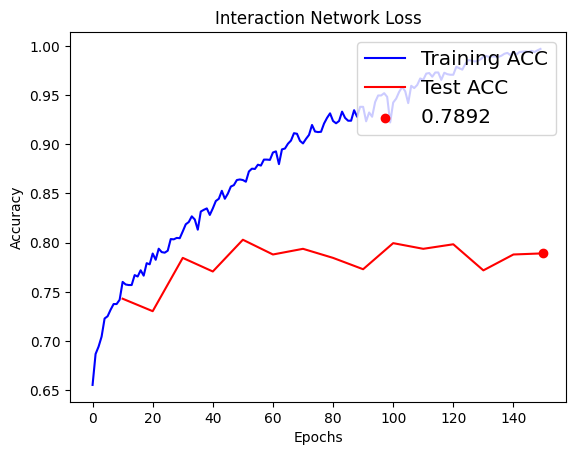

In [4]:
model_args = {
    'name': "GCN",
     'inputs': model_inputs,
     'input_embedding': {"node": {"input_dim": 55, "output_dim": 64},
                         "edge": {"input_dim": 10, "output_dim": 64}},
     'output_embedding': 'graph',
     'output_mlp': {"use_bias": [True, True, False], "units": [140, 70, 1],
                    "activation": ['relu', 'relu', 'sigmoid']},
     'gcn_args': {"units": 64, "use_bias": True, "activation": 'relu', "pooling_method": 'mean'},
     'depth': 3, 'verbose': 1
}
model = make_model(**model_args)

# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

# Compile model with optimizer and loss
optimizer = ks.optimizers.Adam(learning_rate=learning_rate_start)
cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

# Start and time training
start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=0
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Get loss from history
trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.savefig('gcn_explain_mutag_3.png')
plt.show()

## Implement the ExplainableGNN from GNNInterface

In [5]:
class ExplainableGCN(GNNInterface):

    def __init__(self, gnn_model, **kwargs):
        super(ExplainableGCN, self).__init__()
        self.gnn_model = gnn_model

    def predict(self, gnn_input, masking_info=None):
        return self.gnn_model(gnn_input, training=False)[0]

    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input, node_len, edge_len = gnn_input
        
        node_len = ops.convert_to_tensor(node_len)
        edge_len = ops.convert_to_tensor(edge_len)
        edge_index_input = ops.convert_to_tensor(edge_index_input)
        masked_edge_input = ops.convert_to_tensor(edge_input) * ops.cast(edge_mask, dtype="float32")
        masked_feature_input = ops.convert_to_tensor(node_input) * ops.cast(ops.transpose(feature_mask), dtype="float32")
        masked_node_feature_input = ops.convert_to_tensor(masked_feature_input) * ops.cast(node_mask, dtype="float32")
        
        masked_pred = \
        self.gnn_model([masked_node_feature_input, masked_edge_input, edge_index_input, node_len, edge_len], training=training)[0]

        return masked_pred

    def get_number_of_nodes(self, gnn_input):
        # node_input, _, _ = gnn_input
        return gnn_input[0][0].shape[0]

    def get_number_of_node_features(self, gnn_input):
        # node_input, _, _ = gnn_input
        return gnn_input[0].shape[2]

    def get_number_of_edges(self, gnn_input):
        # _, edge_input, _ = gnn_input
        return gnn_input[1][0].shape[0]

    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask):
        edge_relevance = np.array(edge_mask[:, 0])
        node_relevance = np.array(node_mask[:, 0])
        feature_relevance = np.array(feature_mask[:, 0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        graph = nx.Graph()
        num_nodes = gnn_input[3][0]
        num_edges = gnn_input[4][0]
        for i in range(num_nodes):
            f = features[i]
            graph.add_node(i, features=f, relevance=node_relevance[i])
        for i in range(num_edges):
            e = edges[i]
            if edge_relevance is None:
                graph.add_edge(e[0], e[1])
            else:
                graph.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return graph, feature_relevance

    def present_explanation(self, explanation, threshold=0.5):
        graph = explanation[0]
        # element_labels = np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
        element_labels = ['H', 'Li', 'C', 'N', 'O', 'F', 'Na', 'P', 'S', 'Cl', 'K', 'Ca', 'Br', 'I']
        important_edges = []
        color_map = []
        node_color_map = []
        node_labels = {}
        for (u, v, relevance) in graph.edges.data('relevance'):
            relevance = min(relevance + 0.1, 1.0)
            color_map.append((0, 0, 0, relevance))
        for n, f in graph.nodes.data('features'):
            element = np.argmax(f)
            r, g, b, a = plt.get_cmap('tab20')(element)
            node_color_map.append((r, g, b, graph.nodes[n]['relevance']))
            node_labels[n] = (element_labels[element])
        if np.all(explanation[1] == 1):
            nx.draw_kamada_kawai(graph, edge_color=color_map, labels=node_labels, node_color=node_color_map)
        else:
            f, axs = plt.subplots(2, figsize=(8, 12))
            nx.draw_kamada_kawai(graph, ax=axs[0], edge_color=color_map, labels=node_labels, node_color=node_color_map)
            bar_colors = [plt.get_cmap('tab20')(element) for element in np.arange(14)]
            axs[1].bar(np.array(element_labels), explanation[1], color=bar_colors)

Instanciate a Explainable GNN:

In [6]:
explainable_gcn = ExplainableGCN(model)
compile_options = {'loss': 'binary_crossentropy', 'optimizer': ks.optimizers.Adam(learning_rate=0.2)}
fit_options={'epochs': 100, 'batch_size': 1, 'verbose': 0}
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.001,
                 'edge_mask_norm_ord': 1,
                 'feature_mask_loss_weight': 0,
                 'feature_mask_norm_ord': 1,
                 'node_mask_loss_weight': 0,
                 'node_mask_norm_ord': 1}

explainer = GNNExplainer(explainable_gcn,
                              compile_options=compile_options,
                              fit_options=fit_options,
                              gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)

inspection_result = explainer.explain([tensor[776:777] for tensor in xtest], inspection=True)

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras_core\src\optimizers\base_optimizer.py:430: UserWarning: Gradients do not exist for variables ['feature_mask', 'node_mask'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


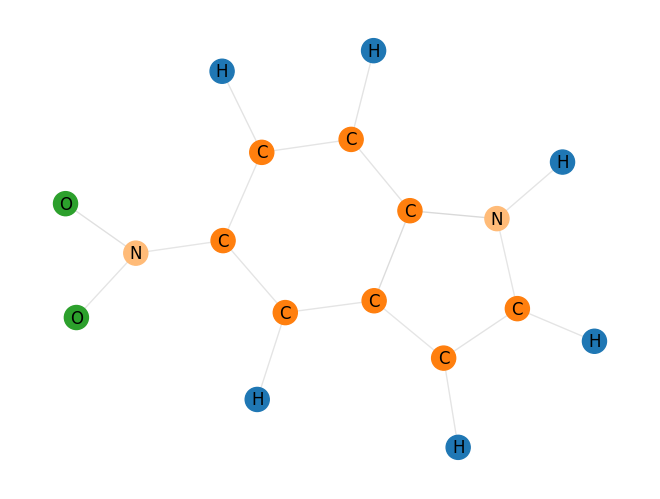

In [7]:
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)

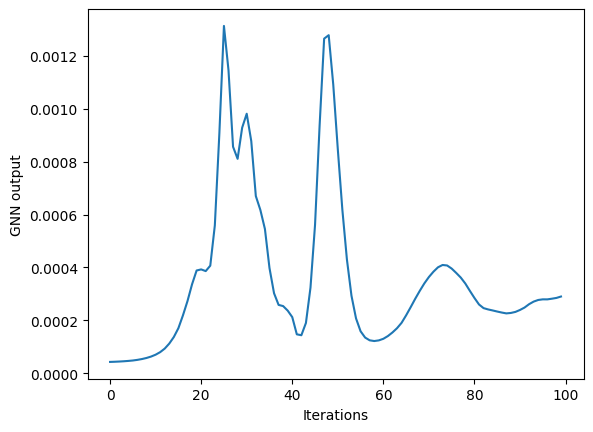

In [8]:
# Plot predicion
plt.figure()
plt.plot(inspection_result['predictions'])
plt.xlabel('Iterations')
plt.ylabel('GNN output')
plt.show()

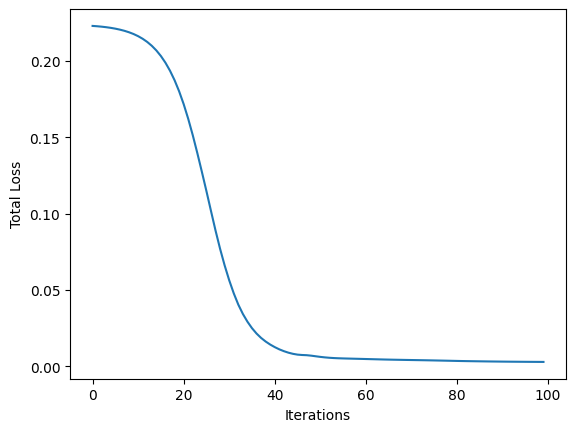

In [9]:
# PLot loss
plt.figure()
plt.plot(inspection_result['total_loss'])
plt.xlabel('Iterations')
plt.ylabel('Total Loss')
plt.show()

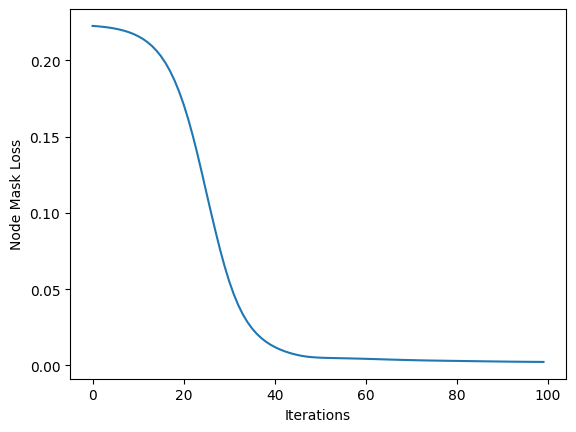

In [10]:
# Plot Edge Mask loss
plt.figure()
plt.plot(inspection_result['edge_mask_loss'])
plt.xlabel('Iterations')
plt.ylabel('Node Mask Loss')
plt.show()

sample 200 mutagenic molecules:

In [11]:
pred = model.predict(xtest)[:,0]
sampled_mutagenic_molecules = np.random.choice(np.argwhere(pred < 0.5)[:,0], 200)
print(sampled_mutagenic_molecules)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step       
[335 586 553  17 201  68 472 417  94  18 321 679  58 134 637 231  82 199
 554 771 785 452 417 506 772 623 564  99 298 764 866 611 237 296 371 668
 115 443 839 375 410 668 675 553 619 430 248 712 233  60 534 249 559 427
 192  75  94 422 379 394 449 320 489 439 106 581 153 186 308 317 306 643
 102 307  68 644  36 359 561 360  68 247 118 316 443  63 830 282 309 258
 100 601 373 249 408 189 825 153 347 227 866  83 756 628 822 822 775 111
 360 584  56 712 616 584 375 599 749 466 819 353 323 499 283 838 264 733
 308 457 418 241 839 499 168 134 316 241   4 223 729 118 284 571 512 684
  44 549  55 376 808 308 486  18 750 603 352 500 436 503 496 114 500 496
 373 406 312 575 187 388 760 676 212 634 706 736 328 167 436 809 622 168
 755 856 755 444  90  28 536 760 789 799 542 554 317 315 481 566 635 766
  75 116]


Generate explanations for all those 50 molecules (this will take a while):

In [12]:
explanations = []
for i,mol_index in enumerate(sampled_mutagenic_molecules):
    explainer.explain([tensor[mol_index:mol_index+1] for tensor in xtest])
    print(i, end=',')
    explanations.append(explainer.get_explanation())

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,

We transform the explanation graphs to vectors, in order to apply a cluster algorithm on the explanation vectors:

In [13]:
def explanation_to_vector(explanation):
    graph = explanation[0]
    bond_matrix = np.zeros((14,14))
    for (u, v, relevance) in graph.edges.data('relevance'):
        atom1 = np.argwhere(graph.nodes[u]['features']==1)[0]
        atom2 = np.argwhere(graph.nodes[v]['features']==1)[0]
        bond_matrix[atom1, atom2] += relevance
        bond_matrix[atom2, atom1] += relevance
    bond_vector = bond_matrix[np.triu_indices(bond_matrix.shape[0])]
    bond_vector = bond_vector / np.sum(bond_vector)
    return bond_vector
explanation_vectors = [explanation_to_vector(expl) for expl in explanations]

a dendogram of the explanation vectors:

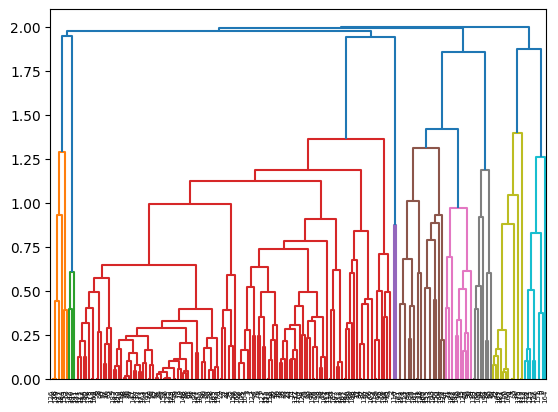

In [14]:
plt.figure()
linked = linkage(explanation_vectors, 'complete', metric='cityblock')
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

Print one representative graph explanation for each cluster:

(38, 105)


C:\Users\patri\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


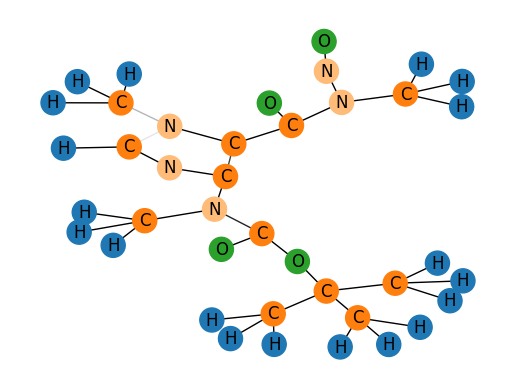

(128, 105)


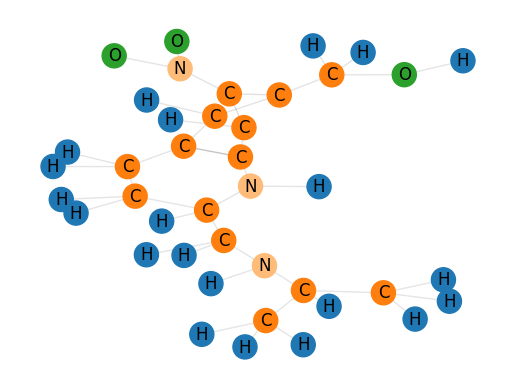

(13, 105)


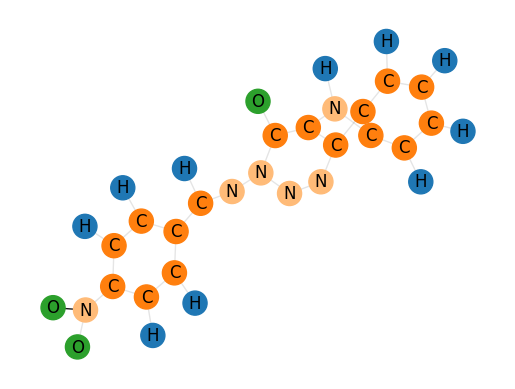

(7, 105)


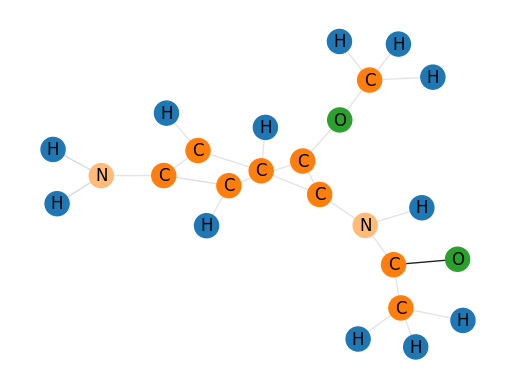

(3, 105)


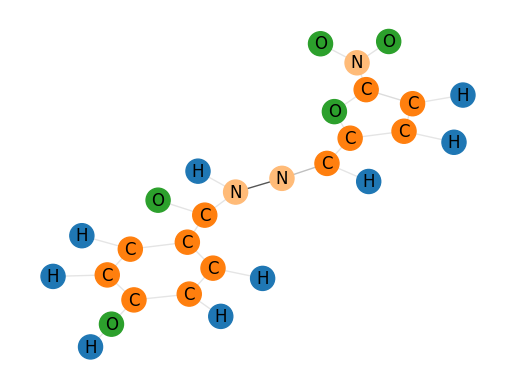

(2, 105)


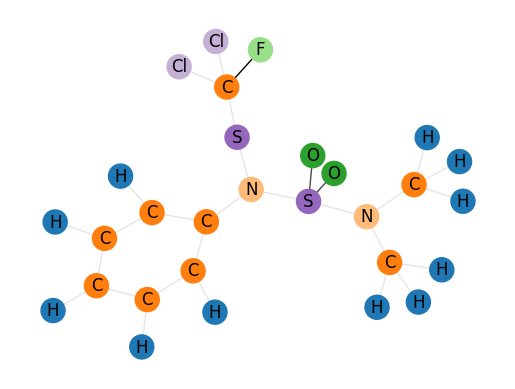

(9, 105)


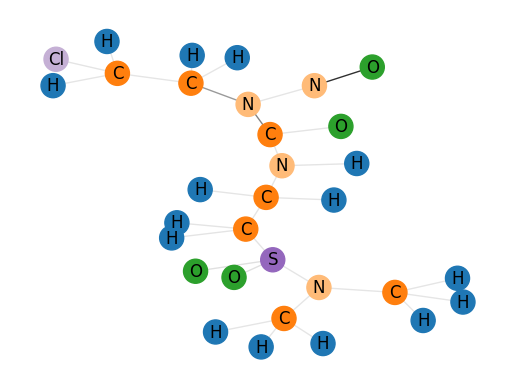

In [15]:
num_clusters = 7
db = AgglomerativeClustering(n_clusters=num_clusters, affinity='manhattan', linkage='complete').fit(explanation_vectors)
vector_clusters = []
explanation_clusters = []
for cluster_ind in range(num_clusters):
    plt.figure()
    vector_cluster = np.array([explanation_vectors[i] for i in np.argwhere(db.labels_ == cluster_ind)[:,0]])
    vector_clusters.append(vector_cluster)
    explanation_cluster = [explanations[i] for i in np.argwhere(db.labels_ == cluster_ind)[:,0]]
    explanation_clusters.append(explanation_cluster)
    cluster_mean = np.mean(vector_cluster, axis=0)
    dist = cdist(np.array([cluster_mean]), vector_cluster)[0]
    print(vector_cluster.shape)
    ax = plt.subplot()
    explainer.present_explanation(explanation_cluster[np.argmin(dist)])
    plt.show()